In [10]:
library(dplyr)
library(ggplot2)
library(scales)
library(tidyverse)
library(tidyr)
library(lubridate)
library(cowplot)

In [12]:
epi_final <- (read.csv('../data/epi_score_final_2.csv')[,-1])


In [13]:
str(epi_final)

'data.frame':	2094081 obs. of  26 variables:
 $ Sample.1            : chr  "N19-03997" "N19-03997" "N19-03999" "N19-04000" ...
 $ Sample.2            : chr  "N19-03999" "N19-04000" "N19-04000" "N19-04001" ...
 $ wg_snps             : int  18400 18218 18389 18550 18323 18848 18860 18908 19408 0 ...
 $ cs_snps             : int  17497 17507 17404 17209 17298 18467 18501 18283 18915 0 ...
 $ Hospital.x          : chr  "Mount Sinai Hospital" "Mount Sinai Hospital" "Mount Sinai Hospital" "Mount Sinai Hospital" ...
 $ Date.of.Collection.x: chr  "2018-07-23" "2018-07-23" "2018-07-28" "2018-07-27" ...
 $ Source.x            : chr  "Clinical" "Clinical" "Clinical" "Clinical" ...
 $ Patient.x           : chr  "M0002" "M0002" "M0006" "M0009" ...
 $ SequenceType.x      : chr  "Novel" "Novel" "244" "27" ...
 $ HOSP.x              : chr  "M" "M" "M" "M" ...
 $ ROOM.x              : chr  NA NA NA NA ...
 $ Hospital.y          : chr  "Mount Sinai Hospital" "Mount Sinai Hospital" "Mount Sinai Hospital"

In [15]:


pat_pat_adm_data <- read.csv('../data/pat_pat_adm_data.csv')[,-1]
df1 <- merge(epi_final, pat_pat_adm_data, by.x = 'Sample.1', by.y = 'sample', all.x = TRUE)
df1 <- df1 %>% select(!Source)
df2 <- merge(df1, pat_pat_adm_data, by.x = 'Sample.2', by.y = 'sample', all.x = TRUE)
# pat_pat_adm_data
dim(df1)
dim(df2)

[1] 2094081      28

[1] 2094081      31

In [20]:
df2 <- df2 %>% mutate(score_cat = epi_score)
 
df2 <- df2 %>% mutate(score_cat = case_when(epi_score >=8  ~ 'High',
                                             epi_score >=4  ~ 'Medium',
                                              epi_score >=3  ~ 'Low',
                                              epi_score >=0  ~ 'Not-linked'))

df2 <- df2 %>% mutate(score_cat=case_when(Patient.x !='n/a' & Patient.x==Patient.y ~ 'Same Patient',
                                                             TRUE ~ score_cat))

df2 <- df2 %>% mutate(score_cat = case_when(Hospital.x == Hospital.y & Patient.x == 'n/a' & Patient.y == 'n/a' & contains_same_value == TRUE ~ 'Same Room',
                                         TRUE ~ score_cat))


In [21]:
### complete Epi Data

df3 <- df2 %>%
filter(Source.x == 'Clinical') %>%
filter(Source.x == Source.y) %>%
  filter(AdmissionData.x == 'Yes') %>%
  filter(AdmissionData.y == 'Yes') 

df4 <- df2 %>% 
filter(Source.x != Source.y) %>%
  filter(!(is.na(nRoom.x))) %>%
         filter(!(is.na(nRoom.y)))

df5 <- df2 %>%
filter(Source.x == 'Environmental') %>%
filter(Source.x == Source.y) %>%
  filter(!(is.na(nRoom.x))) %>%
         filter(!(is.na(nRoom.y)))

df6 <- rbind(df3,df4, df5)

In [22]:
# Add a tag to df6
df6 <- df6 %>%
  mutate(EpiData = 'Complete')
dim(df6)
# Add a tag to df2 (for rows not in df6)
df2 <- df2 %>%
  mutate(EpiData = 'Incomplete')
dim(df2)

[1] 884136     34

[1] 2094081      34

In [23]:
## complete and incomplete data
df2$pair <- paste(df2$Sample.1,df2$Sample.2)
df6$pair <- paste(df6$Sample.1,df6$Sample.2)

only_in_df2 <- anti_join(df2, df6, by = 'pair')

dim(df6)
# 861366+1232715
dim(only_in_df2)

[1] 884136     34

[1] 1209945      34

In [24]:
df_epidata <- rbind(only_in_df2, df6)

df_epidata_st <- df_epidata %>%
filter(SequenceType.x != 'Novel') %>%
filter(SequenceType.x == SequenceType.y)

dim(df_epidata)
dim(df_epidata_st)

df_epidata_st$score_cat <-  factor(df_epidata_st$score_cat, levels =  c('High','Medium','Low','Not-linked','Same Patient','Same Room', 'NA'))


df_epidata_st_comp <- df_epidata_st %>% 
filter(EpiData == 'Complete') 
dim(df_epidata_st_comp)

[1] 2094081      34

[1] 108978     34

[1] 62378    34

In [25]:
all <- df_epidata_st_comp %>% group_by(score_cat) %>%
tally() %>% filter(!is.na(score_cat)) %>%
mutate(freq = n / sum(n)) %>%
mutate(Category = 'All')

above <- df_epidata_st_comp %>% filter(wg_snps > 24) %>% 
group_by(score_cat) %>%
tally() %>% 
filter(!is.na(score_cat))%>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'Above')

below <- df_epidata_st_comp %>% filter(wg_snps <= 24) %>% 
group_by(score_cat) %>%
tally() %>% 
filter(!is.na(score_cat))%>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'Below')

df <- rbind(all, above, below) 
df$Category <- factor(df$Category, levels = c('All', 'Above','Below'))
df$score_cat <- factor(df$score_cat, levels =  c('High','Medium','Low','Not-linked','Same Patient','Same Room', 'NA'))

score_cat_colors <- c('High'='#771427','Medium'='#AA5C39','Low'='#D4A56A','Not-linked'='#D4CC6A','Same Patient'='#672770','Same Room'='#457585', 'NA'='grey')


In [27]:
# Filter out "Same Patient" and "Same Room"
filtered_data <- df  
# %>% filter(score_cat!='Same Patient') %>% 
# filter(score_cat!='Same Room')
# Reshape data for the contingency table
contingency_data <- filtered_data %>%
  select(score_cat, Category, n) %>%
  spread(Category, n, fill = 0)

# Calculate the proportions
contingency_data <- contingency_data %>%
  mutate(Total = Above + Below,
         Prop_Above = Above / Total,
         Prop_Below = Below / Total)
# contingency_data

# Perform significance test for each category
contingency_data <- contingency_data %>%
  rowwise() %>%
  mutate(p_value = prop.test(c(Above, Below), c(Total, Total))$p.value,
         signif_label = case_when(
           p_value < 0.001 ~ "***",
           p_value < 0.01 ~ "**",
           p_value < 0.05 ~ "*",
           TRUE ~ ""
         ))

# Reshape data for plotting
plot_data <- contingency_data %>%
  select(score_cat, Prop_Above, Prop_Below) %>%
  gather(key = "Category", value = "Proportion", -score_cat)
plot_data$Category <- (as.factor(plot_data$Category))


In [28]:
# Add significance labels in the middle of the bars
significance_labels <- contingency_data %>%
  filter(signif_label != "") %>%
  select(score_cat, signif_label) %>%
  mutate(x_position = as.numeric(factor(score_cat)) - 0.5,
         y_position = 0.95)  # Adjust y_position as needed
    # rename(Category = 'score_cat')
significance_labels
significance_labels <- cbind(significance_labels, x_pos = c(1,2,3,4,5,6))
significance_labels <- significance_labels %>% rename(Category = 'score_cat')

score_cat,signif_label,x_position,y_position
<fct>,<chr>,<dbl>,<dbl>
High,**,0.5,0.95
Medium,***,0.5,0.95
Low,***,0.5,0.95
Not-linked,***,0.5,0.95
Same Patient,***,0.5,0.95
Same Room,***,0.5,0.95


In [29]:
plot_data$Category <- factor(
  plot_data$Category, 
  levels = c("Prop_Above", "Prop_Below")
)


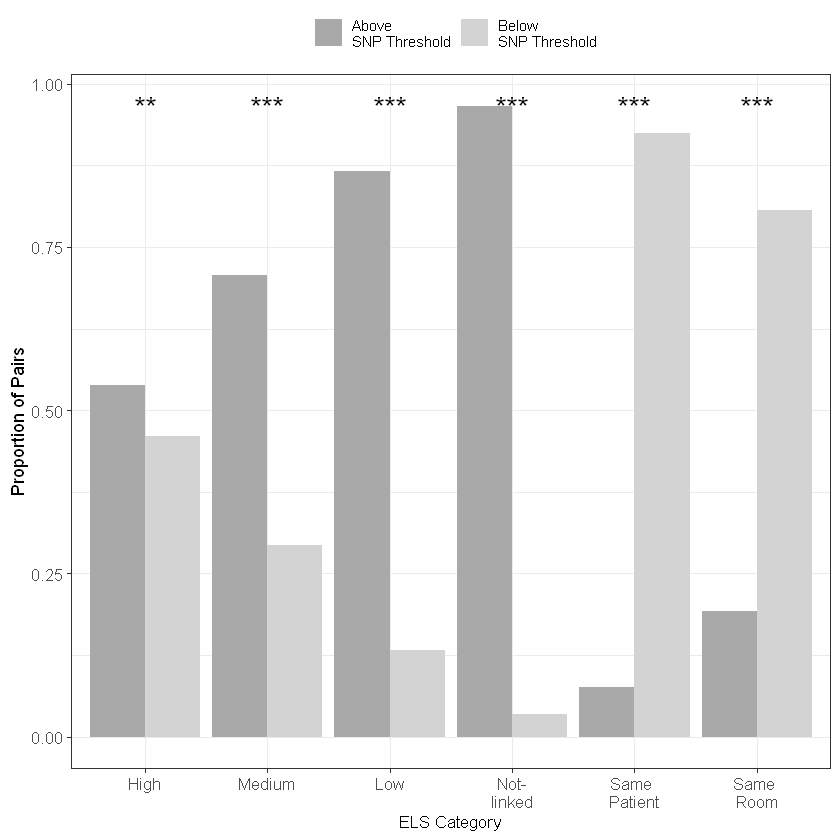

In [30]:

# Create the dodge bar plot with significance
fig5av2 <- ggplot(plot_data, aes(x = score_cat, y = Proportion, fill = Category)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9))+
  geom_text(data = significance_labels, 
            aes(x =x_pos , y = y_position, label = signif_label), 
            inherit.aes = FALSE, 
            vjust = 0, size = 6, show.legend = FALSE)+
  scale_fill_manual(values = c("Prop_Above" = "darkgray", "Prop_Below" = "lightgray"), labels = c('Above \nSNP Threshold','Below \nSNP Threshold' ), name = '') +
  labs(y = "Proportion of Pairs", x = "ELS Category", fill = "Category") +
   theme_bw() +
  theme(legend.position = "top")+
theme(axis.title.x = element_text(size=10),
      axis.title.y =  element_text(size=11),
      axis.text.x =  element_text(size=10),
      axis.text.y =  element_text(size=10))+
scale_x_discrete(labels = c("High" = "High", "Medium" =  "Medium", "Low" = "Low", "Not-linked" = "Not-\nlinked", "Same Patient"="Same \nPatient", "Same Room"="Same \nRoom" ) )

fig5av2 

score_cat,signif_label,x_position,y_position
<fct>,<chr>,<dbl>,<dbl>
High,***,0.5,0.85
Medium,***,0.5,0.85
Low,***,0.5,0.85
Not-linked,***,0.5,0.85


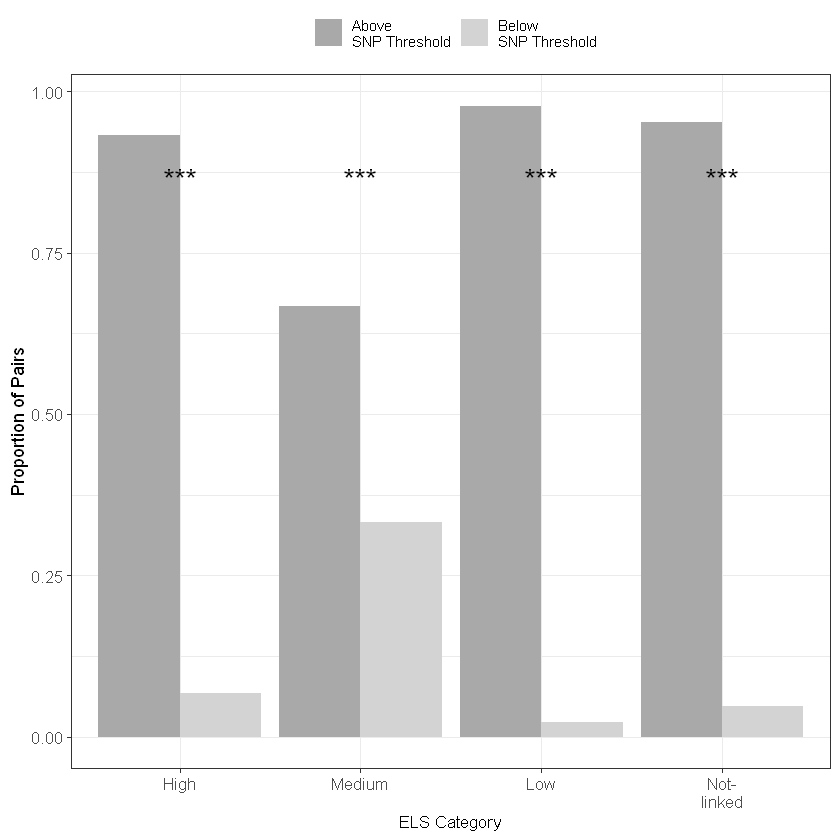

In [31]:
all <- df_epidata_st_comp %>% 
filter(Source.x == 'Clinical') %>%
filter(Source.x == Source.y) %>%
filter(Patient.x != Patient.y) %>%
group_by(score_cat) %>%
tally() %>% filter(!is.na(score_cat)) %>%
mutate(freq = n / sum(n)) %>%
mutate(Category = 'All')

above <- df_epidata_st_comp %>% 
filter(Source.x == 'Clinical') %>%
filter(Source.x == Source.y) %>%
filter(Patient.x != Patient.y) %>%
filter(wg_snps > 24) %>% 
group_by(score_cat) %>%
tally() %>% 
filter(!is.na(score_cat))%>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'Above')

below <- df_epidata_st_comp %>%
filter(Source.x == 'Clinical') %>%
filter(Source.x == Source.y) %>%
filter(Patient.x != Patient.y) %>%
filter(wg_snps <= 24) %>% 
group_by(score_cat) %>%
tally() %>% 
filter(!is.na(score_cat))%>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'Below')

df <- rbind(all, above, below) 
df$Category <- factor(df$Category, levels = c('All', 'Above','Below'))
df$score_cat <- factor(df$score_cat, levels =  c('High','Medium','Low','Not-linked','Same Patient','Same Room', 'NA'))


# Filter out "Same Patient" and "Same Room"
filtered_data <- df 
# Reshape data for the contingency table
contingency_data <- filtered_data %>%
  select(score_cat, Category, n) %>%
  spread(Category, n, fill = 0)

# Calculate the proportions
contingency_data <- contingency_data %>%
  mutate(Total = Above + Below,
         Prop_Above = Above / Total,
         Prop_Below = Below / Total)
# contingency_data
# Perform significance test for each category
contingency_data <- contingency_data %>%
  rowwise() %>%
  mutate(p_value = prop.test(c(Above, Below), c(Total, Total))$p.value,
         signif_label = case_when(
           p_value < 0.001 ~ "***",
           p_value < 0.01 ~ "**",
           p_value < 0.05 ~ "*",
           TRUE ~ ""
         ))

# Reshape data for plotting
plot_data <- contingency_data %>%
  select(score_cat, Prop_Above, Prop_Below) %>%
  gather(key = "Category", value = "Proportion", -score_cat)
# plot_data

# Add significance labels in the middle of the bars
significance_labels <- contingency_data %>%
  filter(signif_label != "") %>%
  select(score_cat, signif_label) %>%
  mutate(x_position = as.numeric(factor(score_cat)) - 0.5,
         y_position = 0.85)  # Adjust y_position as needed
    # rename(Category = 'score_cat')
significance_labels
significance_labels <- cbind(significance_labels, x_pos = c(1,2,3,4))
significance_labels <- significance_labels %>% rename(Category = 'score_cat')


# Create the dodge bar plot with significance
fig5a.2 <- ggplot(plot_data, aes(x = score_cat, y = Proportion, fill = Category)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9)) +
  geom_text(data = significance_labels, 
            aes(x =x_pos , y = y_position, label = signif_label), 
            inherit.aes = FALSE, 
            vjust = 0, size = 6, show.legend = FALSE)+
  labs(y = "Proportion of Pairs", x = "ELS Category", fill = "Category") +
  scale_fill_manual(values = c("Prop_Above" = "darkgray", "Prop_Below" = "lightgray"), labels = c('Above \nSNP Threshold','Below \nSNP Threshold' ), name = '') +
  theme_bw() +
  theme(legend.position = "top")+
theme(axis.title.x = element_text(size=10),
      axis.title.y =  element_text(size=11),
      axis.text.x =  element_text(size=10),
      axis.text.y =  element_text(size=10))+
scale_x_discrete(labels = c("High" = "High", "Medium" =  "Medium", "Low" = "Low", "Not-linked" = "Not-\nlinked", "Same Patient"="Same \nPatient", "Same Room"="Same \nRoom" ) )

fig5a.2 
# ggsave('Figure5av2.png',device = 'png', dpi = 450, height = 4, width = 5 )

score_cat,signif_label,x_position,y_position
<fct>,<chr>,<dbl>,<dbl>
High,***,0.5,0.85
Medium,***,0.5,0.85
Low,***,0.5,0.85
Not-linked,***,0.5,0.85


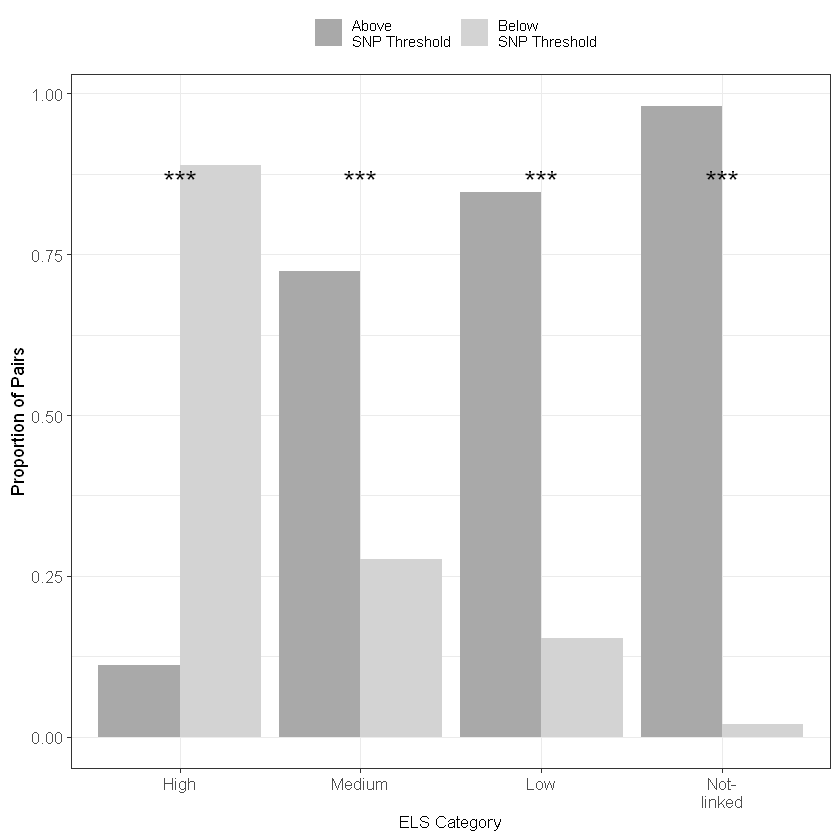

In [32]:
all <- df_epidata_st_comp %>% 
# filter(Source.x == 'Clinical') %>%
filter(Source.x != Source.y) %>%
group_by(score_cat) %>%
tally() %>% filter(!is.na(score_cat)) %>%
mutate(freq = n / sum(n)) %>%
mutate(Category = 'All')

above <- df_epidata_st_comp %>% 
# filter(Source.x == 'Clinical') %>%
filter(Source.x != Source.y) %>%
filter(wg_snps > 24) %>% 
group_by(score_cat) %>%
tally() %>% 
filter(!is.na(score_cat))%>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'Above')

below <- df_epidata_st_comp %>%
# filter(Source.x == 'Clinical') %>%
filter(Source.x != Source.y) %>%
filter(wg_snps <= 24) %>% 
group_by(score_cat) %>%
tally() %>% 
filter(!is.na(score_cat))%>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'Below')

df <- rbind(all, above, below) 
df$Category <- factor(df$Category, levels = c('All', 'Above','Below'))
df$score_cat <- factor(df$score_cat, levels =  c('High','Medium','Low','Not-linked','Same Patient','Same Room', 'NA'))


# Filter out "Same Patient" and "Same Room"
filtered_data <- df 
# Reshape data for the contingency table
contingency_data <- filtered_data %>%
  select(score_cat, Category, n) %>%
  spread(Category, n, fill = 0)

# Calculate the proportions
contingency_data <- contingency_data %>%
  mutate(Total = Above + Below,
         Prop_Above = Above / Total,
         Prop_Below = Below / Total)
# contingency_data
# Perform significance test for each category
contingency_data <- contingency_data %>%
  rowwise() %>%
  mutate(p_value = prop.test(c(Above, Below), c(Total, Total))$p.value,
         signif_label = case_when(
           p_value < 0.001 ~ "***",
           p_value < 0.01 ~ "**",
           p_value < 0.05 ~ "*",
           TRUE ~ ""
         ))
# contingency_data

# Reshape data for plotting
plot_data <- contingency_data %>%
  select(score_cat, Prop_Above, Prop_Below) %>%
  gather(key = "Category", value = "Proportion", -score_cat)
# plot_data

# Add significance labels in the middle of the bars
significance_labels <- contingency_data %>%
  filter(signif_label != "") %>%
  select(score_cat, signif_label) %>%
  mutate(x_position = as.numeric(factor(score_cat)) - 0.5,
         y_position = 0.85)  # Adjust y_position as needed
    # rename(Category = 'score_cat')
significance_labels
significance_labels <- cbind(significance_labels, x_pos = c(1,2,3,4))
significance_labels <- significance_labels %>% rename(Category = 'score_cat')


# Create the dodge bar plot with significance
fig5a.3 <- ggplot(plot_data, aes(x = score_cat, y = Proportion, fill = Category)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9)) +
  geom_text(data = significance_labels, 
            aes(x =x_pos , y = y_position, label = signif_label), 
            inherit.aes = FALSE, 
            vjust = 0, size = 6, show.legend = FALSE)+
  labs(y = "Proportion of Pairs", x = "ELS Category", fill = "Category") +
  scale_fill_manual(values = c("Prop_Above" = "darkgray", "Prop_Below" = "lightgray"), labels = c('Above \nSNP Threshold','Below \nSNP Threshold' ), name = '') +
  theme_bw() +
  theme(legend.position = "top")+
theme(axis.title.x = element_text(size=10),
      axis.title.y =  element_text(size=11),
      axis.text.x =  element_text(size=10),
      axis.text.y =  element_text(size=10))+
scale_x_discrete(labels = c("High" = "High", "Medium" =  "Medium", "Low" = "Low", "Not-linked" = "Not-\nlinked", "Same Patient"="Same \nPatient", "Same Room"="Same \nRoom" ) )

fig5a.3 
# ggsave('Figure5av2.png',device = 'png', dpi = 450, height = 4, width = 5 )

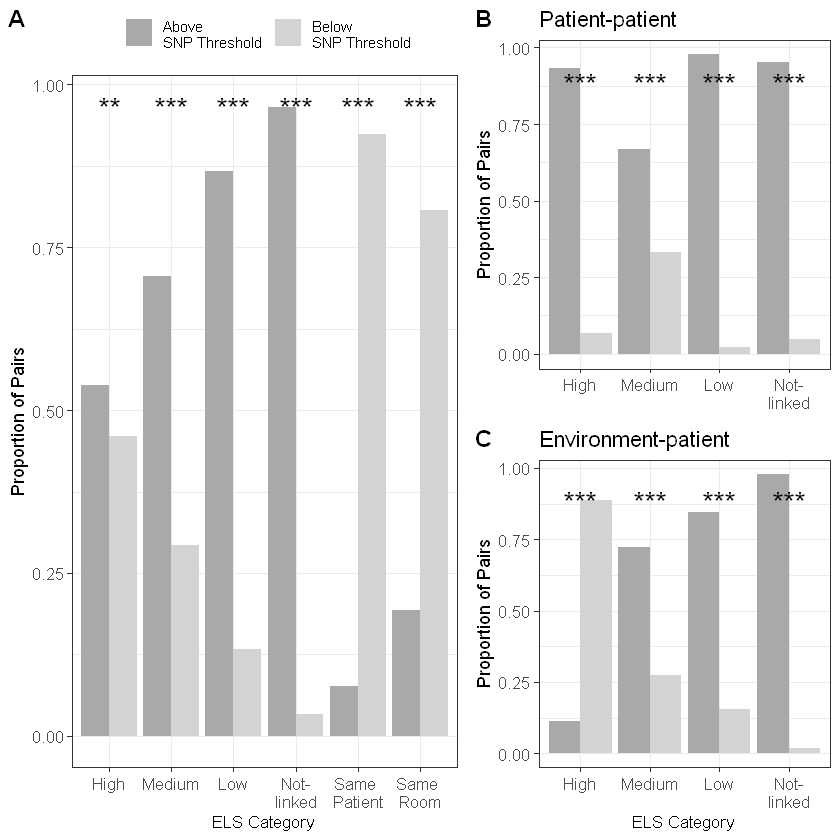

In [33]:
fig5_12 <- plot_grid(fig5a.2+theme(legend.position = 'none', axis.title.x = element_blank())+ggtitle('Patient-patient'), 
          fig5a.3+theme(legend.position = 'none')+ggtitle('Environment-patient'),
                     ncol = 1, labels = c('B', 'C'))

fig5A <- plot_grid(fig5av2, fig5_12, ncol=2, labels = 'A', rel_widths = c(1,0.8))
fig5A

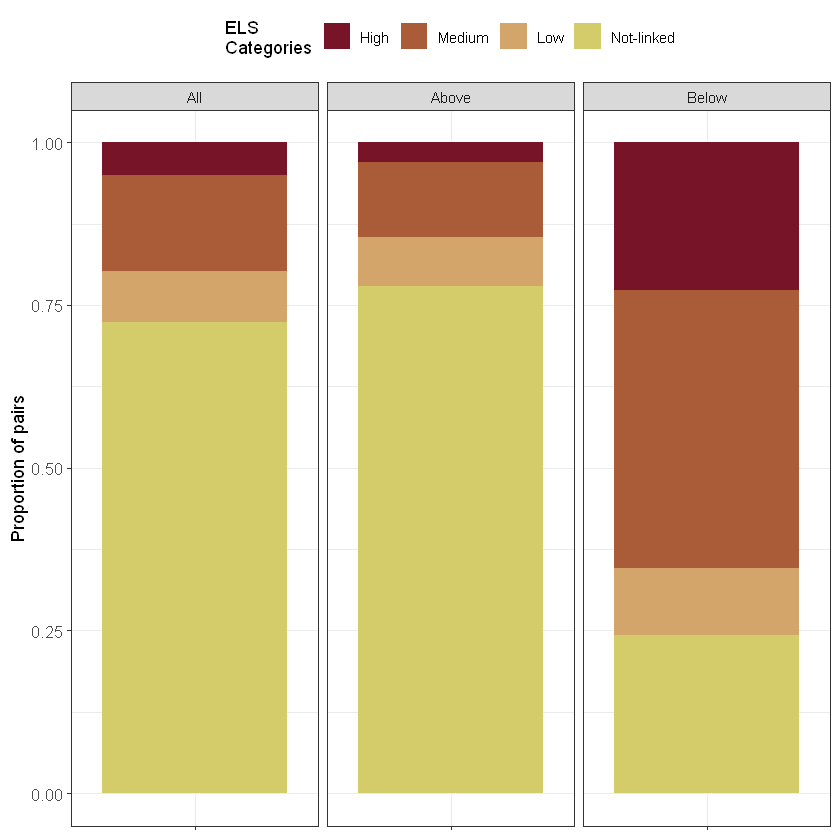

In [34]:
df_epidata_eCTP <- df_epidata_st_comp %>% 
filter(EpiData == 'Complete') %>%
filter(!score_cat %in% c('Same Patient','Same Room', 'NA')) 
# filter(contains_same_value)

all <- df_epidata_eCTP %>% group_by(score_cat) %>%
tally() %>% filter(!is.na(score_cat)) %>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'All')

above <- df_epidata_eCTP %>% filter(wg_snps > 24) %>% 
group_by(score_cat) %>%
tally() %>% 
filter(!is.na(score_cat))%>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'Above')

below <- df_epidata_eCTP %>% filter(wg_snps <= 24) %>% 
group_by(score_cat) %>%
tally() %>% 
filter(!is.na(score_cat))%>%
mutate(freq = n / sum(n))%>%
mutate(Category = 'Below')

df <- rbind(all, above, below) 
df$Category <- factor(df$Category, levels = c('All', 'Above','Below'))
df$score_cat <- factor(df$score_cat, levels =  c('High','Medium','Low','Not-linked','Same Patient','Same Room', 'NA'))

score_cat_colors <- c('High'='#771427','Medium'='#AA5C39','Low'='#D4A56A','Not-linked'='#D4CC6A','Same Patient'='#672770','Same Room'='#457585', 'NA'='grey')

fig5B <- df %>%
ggplot()+
aes(y = freq, x = Category, fill=score_cat)+
geom_bar(stat='identity')+ylab('Proportion of pairs')+
facet_wrap(~Category, scales = 'free_x')+
scale_fill_manual(values = score_cat_colors, name='ELS \nCategories')+
theme_bw() + theme(legend.position = "top")+
theme(axis.title.x = element_blank(),
      axis.title.y =  element_text(size=11),
      axis.text.x =  element_blank(),
      axis.text.y =  element_text(size=10))

fig5B

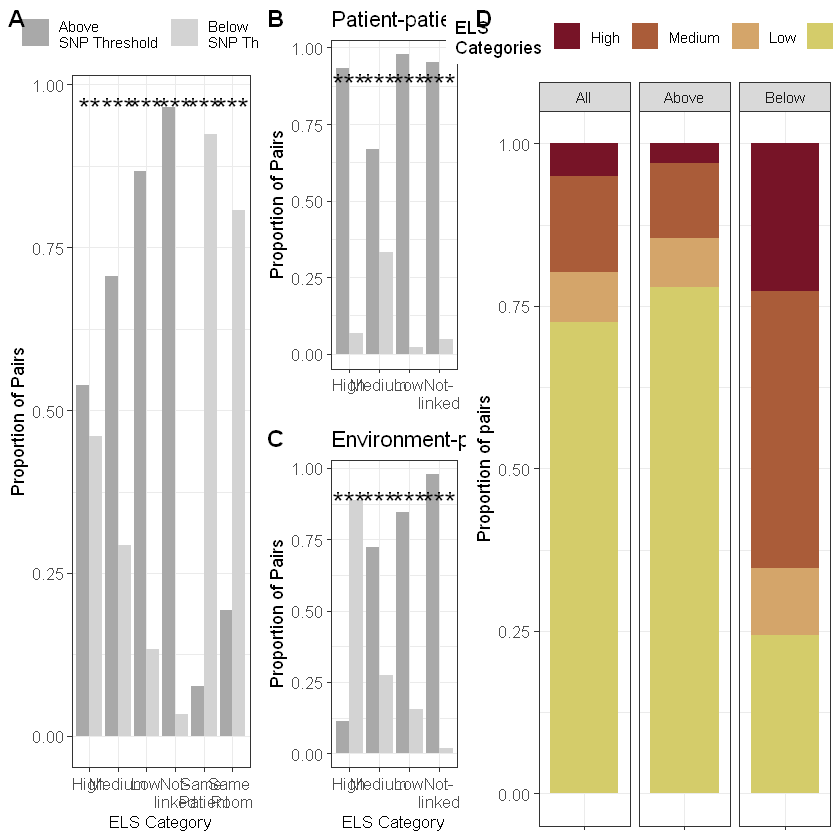

In [35]:
plot_grid(fig5A, fig5B, labels = c('','D'), rel_widths = c(1,0.8))

ggsave('../output/Figure.png', device = 'png', dpi = 450, width = 12, height = 5)

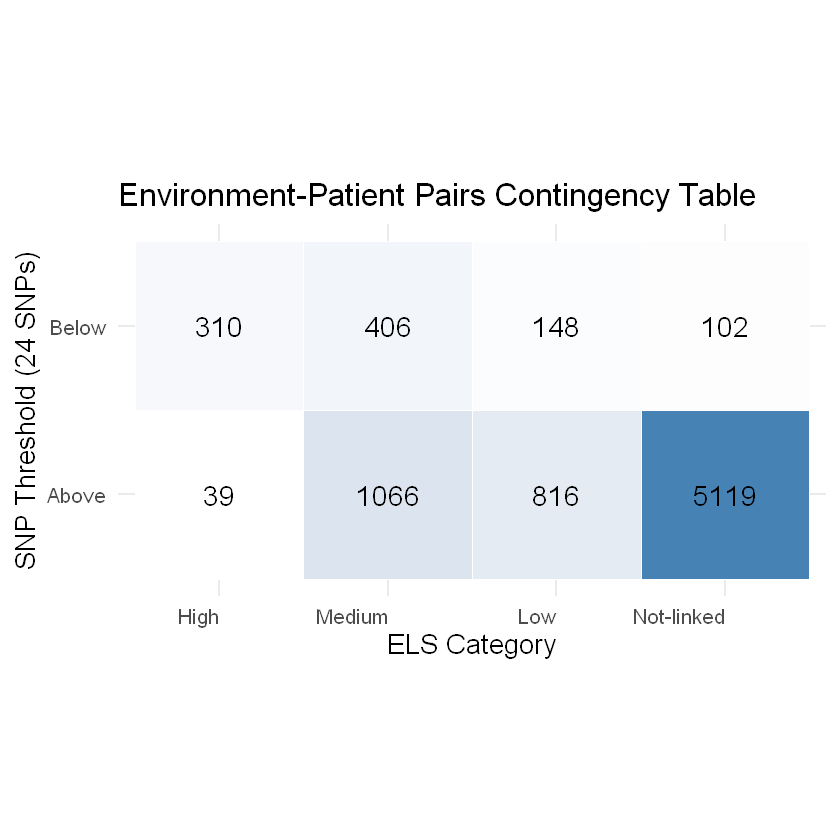

In [36]:
df_epidata_st_comp  %>%
  filter(Source.x != Source.y) %>%
  mutate(snp_cat = ifelse(wg_snps <= 24, "Below", "Above")) %>%
  count(snp_cat, score_cat) %>%
  ggplot(aes(x = score_cat, y = snp_cat, fill = n)) +
  geom_tile(color = "white") +
  geom_text(aes(label = n), color = "black", size = 6) +   # increase text size inside cells
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(x = "ELS Category", y = "SNP Threshold (24 SNPs)",
       title = "Environment-Patient Pairs Contingency Table") +
  theme_minimal(base_size = 16) +                          # increase axis/title fonts
  theme(
    legend.position = "none",                              # remove legend
    axis.text.x = element_text(angle = 0, hjust = 1)      # tilt x labels if long
  ) +
  coord_fixed(ratio = 1)                # keep tiles square